In [9]:
stock_code = "2881"           # 台灣上市公司代碼（TWSE）
start_date = "2023-01-01"     # 起始日（含）
end_date   = "2024-12-31"     # 結束日（含）

import pandas as pd
import numpy as np
import requests, time
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 6)
print("Target:", stock_code, start_date, "→", end_date)

Target: 2881 2023-01-01 → 2024-12-31


In [10]:
import datetime as dt

def _to_num(x):
    # 去掉千分位與特殊符號；失敗轉 NaN
    return pd.to_numeric(str(x).replace(",", "").replace("--", ""), errors="coerce")

def _parse_twse_date(s: str) -> pd.Timestamp:
    """
    TWSE 回傳日期可能是民國年 '112/09/01' 或西元 '2024/09/01'，統一轉 Timestamp（無時區）
    """
    y, m, d = map(int, str(s).split("/"))
    if y < 1911:  # 民國年
        y += 1911
    return pd.Timestamp(year=y, month=m, day=d)

def fetch_twse_stock_day(stock_no: str, start: str, end: str, pause=0.3) -> pd.DataFrame:
    """
    逐月打 TWSE API: https://www.twse.com.tw/exchangeReport/STOCK_DAY
    回傳欄位：Date, Open_TWSE, Close_TWSE, Volume_TWSE
    """
    start_dt = pd.to_datetime(start)
    end_dt   = pd.to_datetime(end)

    # 產生逐月清單（含首尾月）
    months = pd.period_range(start=start_dt, end=end_dt, freq="M")
    if len(months) == 0:
        months = pd.period_range(start=start_dt, end=end_dt + pd.offsets.MonthEnd(), freq="M")

    frames = []
    for p in months:
        query_date = f"{p.year}{p.month:02d}01"
        url = "https://www.twse.com.tw/exchangeReport/STOCK_DAY"
        params = {"response": "json", "date": query_date, "stockNo": stock_no}
        headers = {"User-Agent": "Mozilla/5.0"}

        try:
            r = requests.get(url, params=params, headers=headers, timeout=10)
            j = r.json()
        except Exception as e:
            print(f"[TWSE] {p} 下載失敗：{e}")
            continue

        if j.get("stat") != "OK" or not j.get("data"):
            print(f"[TWSE] {p} 無資料或非 OK：{j.get('stat')}")
            continue

        df = pd.DataFrame(j["data"], columns=j["fields"])
        # 統一欄位
        out = pd.DataFrame({
            "Date":        df["日期"].map(_parse_twse_date),
            "Open_TWSE":   df["開盤價"].map(_to_num),
            "Close_TWSE":  df["收盤價"].map(_to_num),
            "Volume_TWSE": df["成交股數"].map(_to_num),   # 單位：股
        })
        frames.append(out)
        time.sleep(pause)  # 禮貌性暫停，避免過於頻繁請求

    if not frames:
        return pd.DataFrame(columns=["Date", "Open_TWSE", "Close_TWSE", "Volume_TWSE"])

    data = pd.concat(frames, ignore_index=True)
    # 清理：去重、依日期排、篩選區間
    data = (data.drop_duplicates(subset=["Date"])
                 .sort_values("Date")
                 .loc[lambda x: (x["Date"] >= start_dt) & (x["Date"] <= end_dt)]
                 .reset_index(drop=True))

    print("TWSE 取得筆數：", len(data))
    return data

twse = fetch_twse_stock_day(stock_code, start_date, end_date)
twse.head()

TWSE 取得筆數： 481


,Date,Open_TWSE,Close_TWSE,Volume_TWSE
0,2023-01-03,56.1,56.4,7590880
1,2023-01-04,56.5,57.2,8313409
2,2023-01-05,57.4,58.5,15767274
3,2023-01-06,58.4,58.5,8060454
4,2023-01-09,59.0,59.6,19905396


In [11]:
# 交作業時若只要 Open/Close，也可以不包含 Volume；這裡保留 Volume 方便畫圖
df = twse.rename(columns={
    "Open_TWSE":  "Open",
    "Close_TWSE": "Close",
    "Volume_TWSE":"Volume"
})[["Date", "Open", "Close", "Volume"]].copy()

df.tail(3)

,Date,Open,Close,Volume
478,2024-12-27,91.5,91.8,5953248
479,2024-12-30,91.5,91.3,6525285
480,2024-12-31,90.7,90.3,16198944


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38283 (\N{CJK UNIFIED IDEOGRAPH-958B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30436 (\N{CJK UNIFIED IDEOGRAPH-76E4}) missing from font(s) DejaVu Sans.
  fig.canva

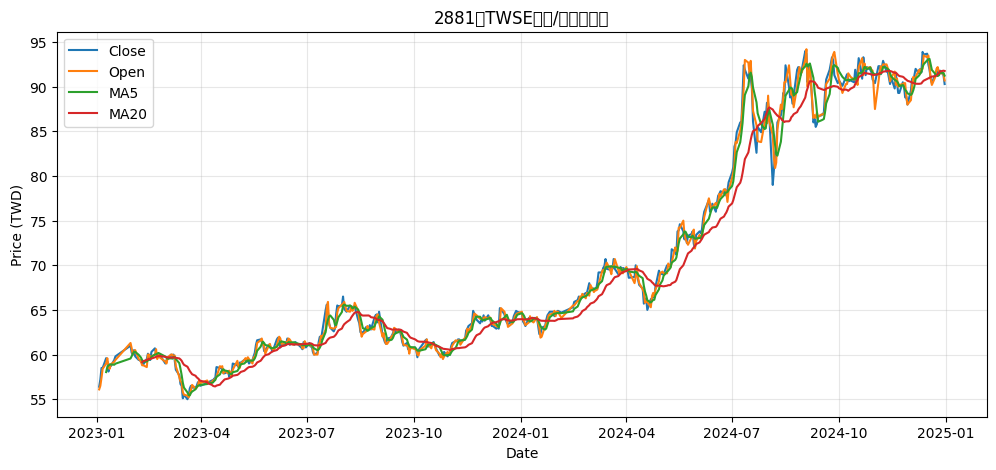

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


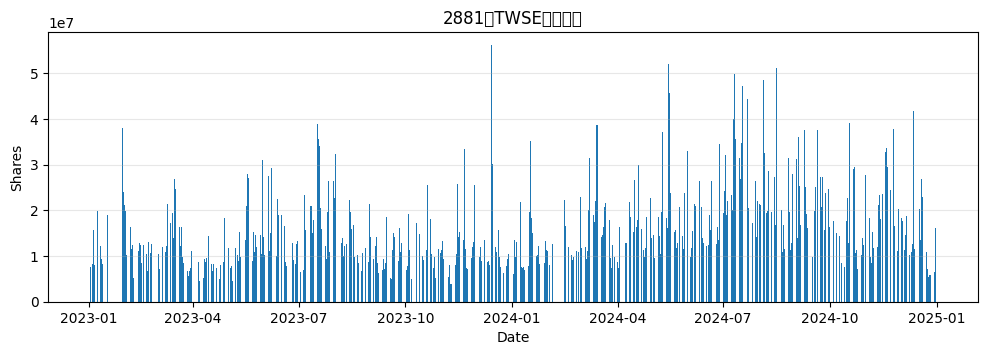

In [12]:
plot = df.set_index("Date").sort_index()
plot["MA5"]  = plot["Close"].rolling(5).mean()
plot["MA20"] = plot["Close"].rolling(20).mean()

# 收盤/開盤 + 均線
plt.figure(figsize=(12,5))
plt.plot(plot.index, plot["Close"], label="Close")
plt.plot(plot.index, plot["Open"],  label="Open")
plt.plot(plot.index, plot["MA5"],   label="MA5")
plt.plot(plot.index, plot["MA20"],  label="MA20")
plt.title(f"{stock_code}（TWSE）開/收盤與均線")
plt.xlabel("Date"); plt.ylabel("Price (TWD)")
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

# 成交量
plt.figure(figsize=(12,3.5))
plt.bar(plot.index, plot["Volume"])
plt.title(f"{stock_code}（TWSE）成交量")
plt.xlabel("Date"); plt.ylabel("Shares")
plt.grid(True, axis="y", alpha=0.3)
plt.show()